In [27]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, alpha, notes, use_strip=False, dagma_knockoff=True):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    
    ax.set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1 | {notes}')
    
    return df

def z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_strip=False, alpha=0.5):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"

    data_dict = {
        "min_depth": [],
        "Z": [],
        "label": []
    }
    
    G = nx.DiGraph(B_true.astype(int))
    start_nodes = np.where(B_true.sum(axis=0) == 0)[0]
    
    min_depth = {}
    for n in G.nodes:
        depth = []
        _depth = dict(nx.single_target_shortest_path_length(G, target=n))
        for st_n in start_nodes:
            depth.append(_depth.get(st_n, np.inf))
        depth = np.array(depth)
        min_depth[n] = depth.min()

    min_depth_uni = np.unique(list(min_depth.values()))
    for min_d in min_depth_uni:
        _n_mask = np.where(
            np.array(list(min_depth.values())) == min_d
        )[0]
        n_mask = np.full(len(B_true), fill_value=False)
        n_mask[_n_mask] = True

        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
        
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['min_depth'].extend([min_d] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    sns.boxplot(df, x='min_depth', y='Z', hue='label', ax=ax, fill=False)
    if use_strip:
        sns.stripplot(df, x='min_depth', y='Z', hue='label', ax=ax, alpha=alpha, dodge=True)
    ax.set_title(f'knockoff statistics Z vs min depth of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    ax.set_xlabel("for each node, min depth from it to all starting nodes")
    ax.set_ylabel("knockoff statistics of edges out of source nodes")
    return df

def sys_z0_vs_depth_box(n_nodes, version_path, seed=1, alpha=0.5, use_strip=True):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_depth_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_strip=use_strip, alpha=alpha)
    return df

def sys_z0_vs_deg_box(n_nodes, version_path, notes, seed=1, alpha=0.5, use_strip=True, remove_self_loop=False):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    real_p = W_est.shape[0]
    if remove_self_loop:
        W_est[np.eye(real_p, real_p).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=real_p // 2).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=-real_p // 2).astype(bool)] = 0.
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=use_strip, alpha=alpha, notes=notes)
    return df

# Test
* Fuck, self loops!

In [11]:
n_nodes = 80
seed = 1
version_path = f'v44/v{n_nodes}_W_true_option_1_lasso_OLS'
X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

In [15]:
mask = (~B_true) & (Z11_21 < -0.5)

In [17]:
np.where(mask)

(array([ 3,  6,  7, 11, 12, 13, 15, 17, 18, 20, 21, 23, 27, 32, 36, 37, 39,
        40, 42, 47, 49, 50, 51, 57, 59, 62, 64, 65, 68, 69, 71, 72, 73, 76]),
 array([ 3,  6,  7, 11, 12, 13, 15, 17, 18, 20, 21, 23, 27, 32, 36, 37, 39,
        40, 42, 47, 49, 50, 51, 57, 59, 62, 64, 65, 68, 69, 71, 72, 73, 76]))

In [33]:
W11

array([[ 0.00000000e+00, -4.58502993e-04, -4.48614701e-01, ...,
        -1.24216599e-02,  1.18331706e-05,  7.37716287e-03],
       [-5.19964854e-05,  0.00000000e+00,  6.57770995e-04, ...,
         3.07611800e-04, -1.26412571e-03, -6.00185259e-05],
       [-4.90493519e-05, -1.97665142e-04,  0.00000000e+00, ...,
         1.38093199e-06,  2.66225861e-05, -3.62040889e-02],
       ...,
       [-2.39300834e-03,  3.03400931e-04,  8.08637597e-03, ...,
         0.00000000e+00,  6.28461569e-04, -1.38205118e-03],
       [ 1.12499007e-05, -7.16342573e-04, -1.03633925e-02, ...,
         4.94352505e-06,  0.00000000e+00,  7.54348033e-04],
       [ 1.46914415e-03,  8.78290767e-07, -1.90367193e-03, ...,
        -1.32942764e-05,  1.81606629e-05,  0.00000000e+00]])

In [35]:
np.diag(W21)

array([4.88126287e-01, 1.48350527e-01, 1.19514482e-04, 5.00290696e-01,
       2.80456994e-04, 3.68114141e-01, 6.92120402e-01, 6.00547126e-01,
       1.29758018e-04, 4.70481637e-01, 6.22697256e-05, 8.18724524e-01,
       5.75280228e-01, 5.50209403e-01, 2.16278850e-01, 5.60022188e-01,
       3.99312141e-01, 5.05954902e-01, 5.84448776e-01, 2.80759711e-01,
       5.31805275e-01, 7.12995390e-01, 3.90462242e-04, 5.94811125e-01,
       1.88951980e-04, 5.30833780e-05, 3.30328605e-01, 5.73190972e-01,
       1.05606957e-01, 3.86413290e-01, 5.05938978e-04, 1.89159084e-03,
       6.94047113e-01, 2.85466865e-02, 6.14461036e-05, 2.31817677e-01,
       7.89302298e-01, 5.92107477e-01, 5.56367576e-04, 5.81401935e-01,
       6.74234973e-01, 2.58376905e-04, 5.19025975e-01, 3.00377252e-01,
       4.66872095e-01, 4.13151531e-01, 7.91020709e-05, 5.84176981e-01,
       3.02522709e-01, 7.33590629e-01, 5.64066972e-01, 6.01020056e-01,
       7.78792094e-05, 2.63648619e-01, 4.62183466e-01, 9.02137046e-05,
      

# cool option 1!

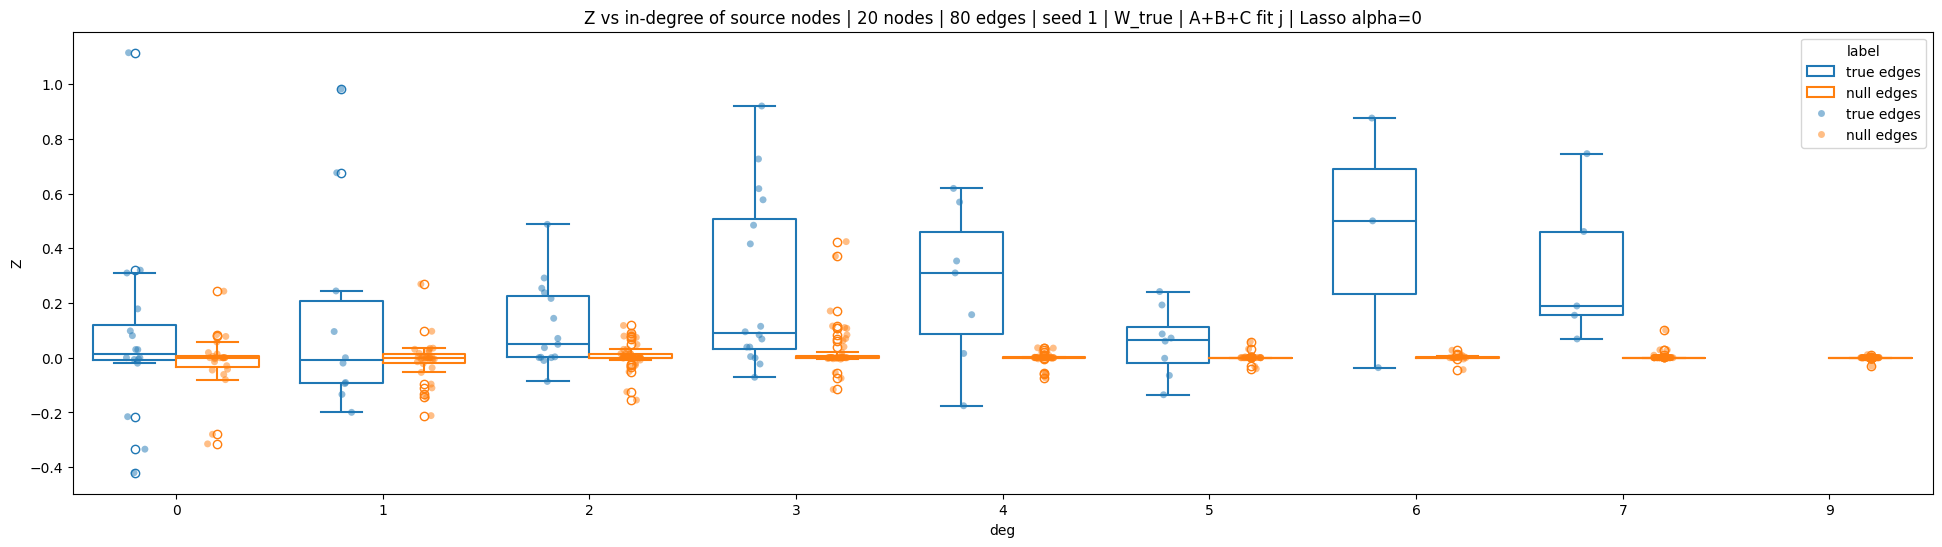

In [31]:
n_nodes = 20
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_1_lasso_OLS', notes='W_true | A+B+C fit j | Lasso alpha=0', remove_self_loop=True)

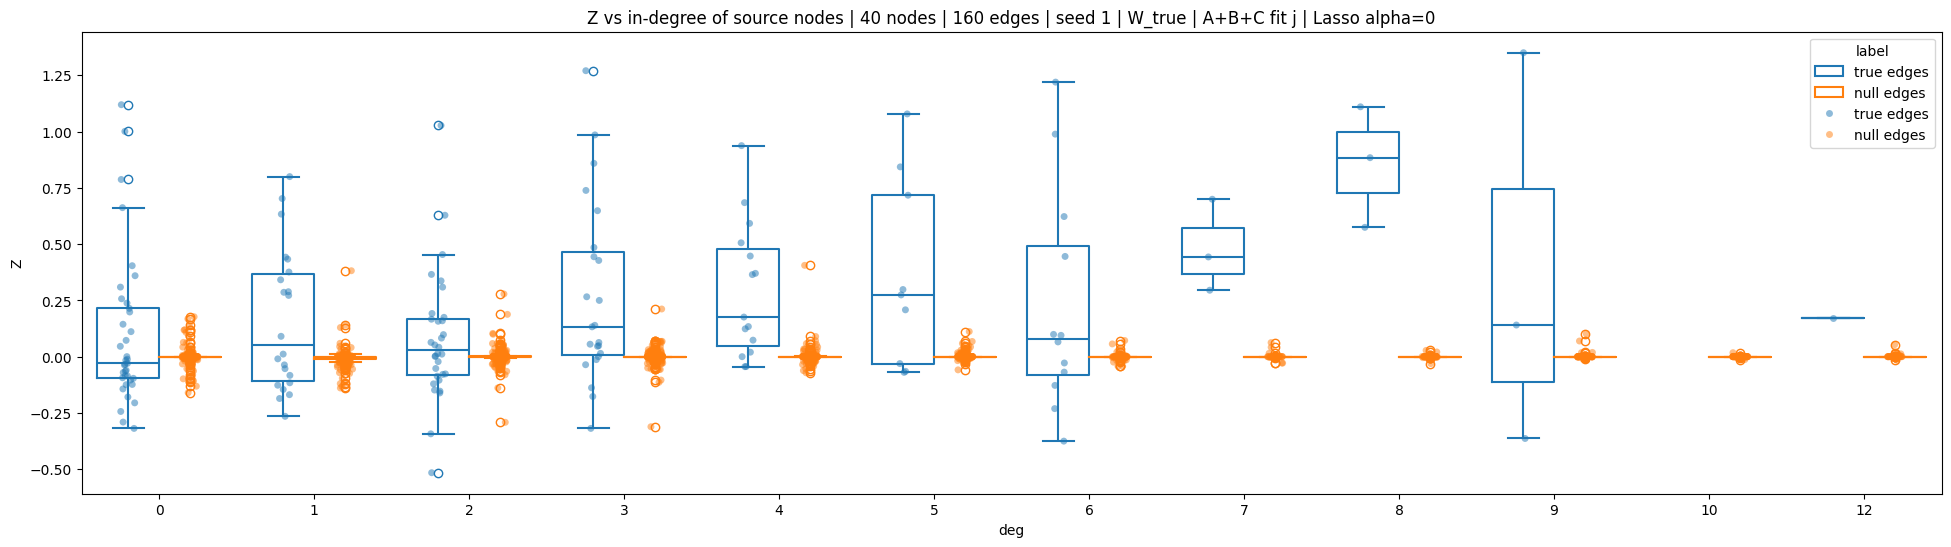

In [30]:
n_nodes = 40
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_1_lasso_OLS', notes='W_true | A+B+C fit j | Lasso alpha=0', remove_self_loop=True)

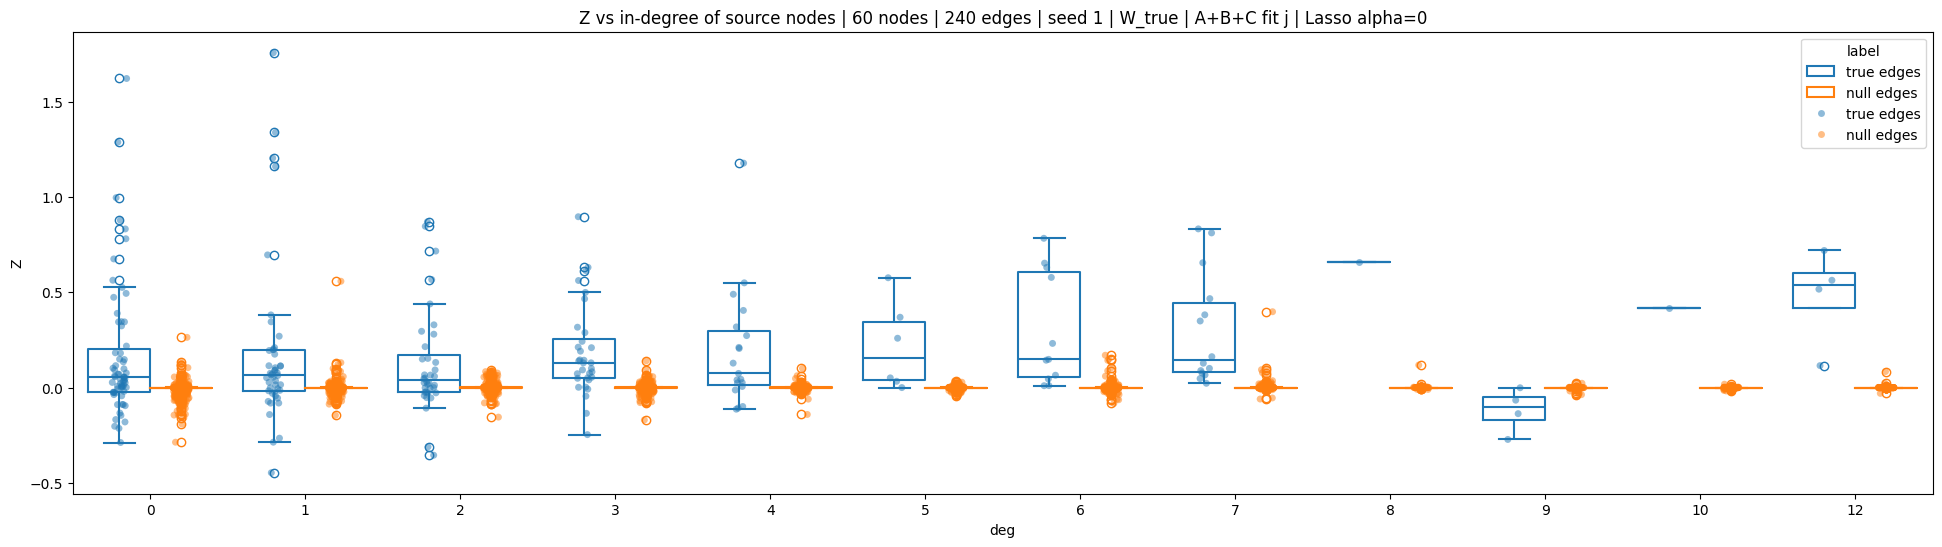

In [29]:
n_nodes = 60
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_1_lasso_OLS', notes='W_true | A+B+C fit j | Lasso alpha=0', remove_self_loop=True)

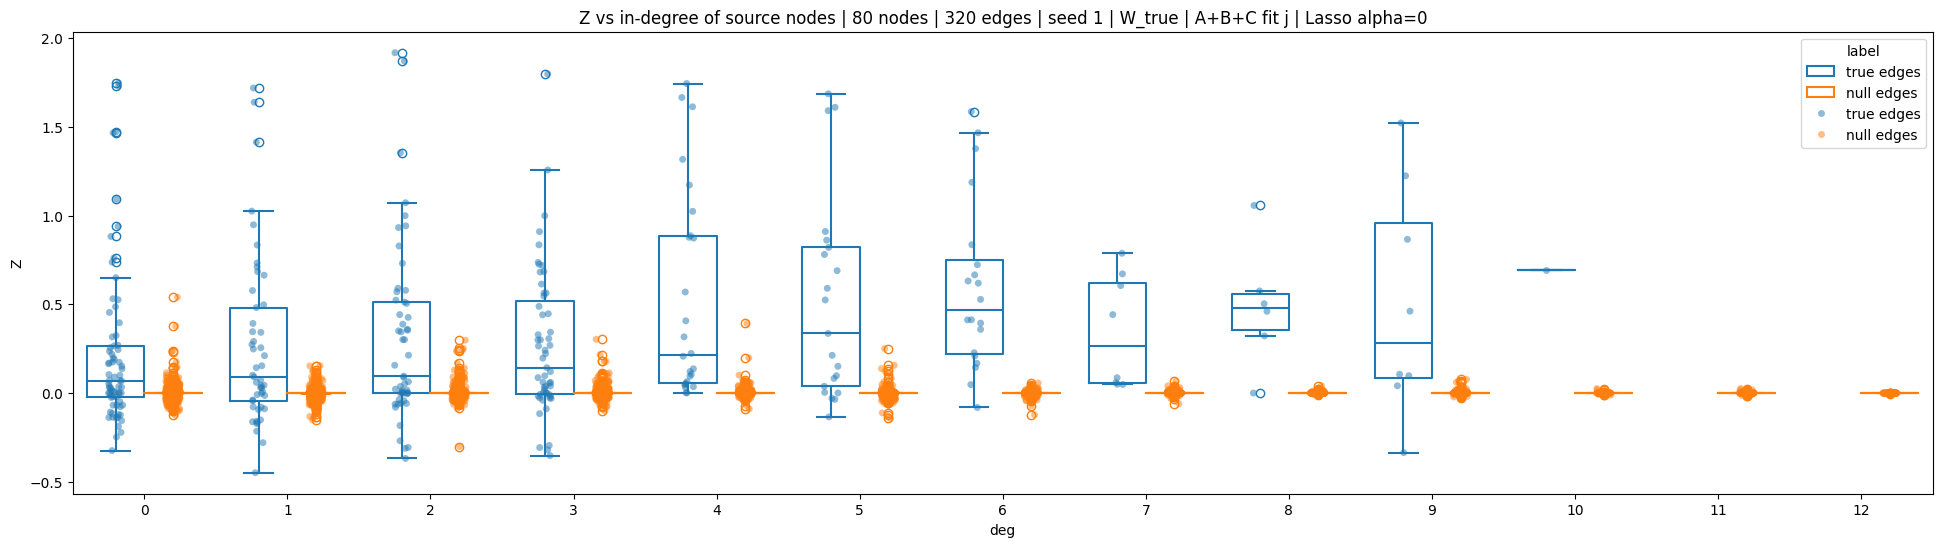

In [28]:
n_nodes = 80
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_1_lasso_OLS', notes='W_true | A+B+C fit j | Lasso alpha=0', remove_self_loop=True)

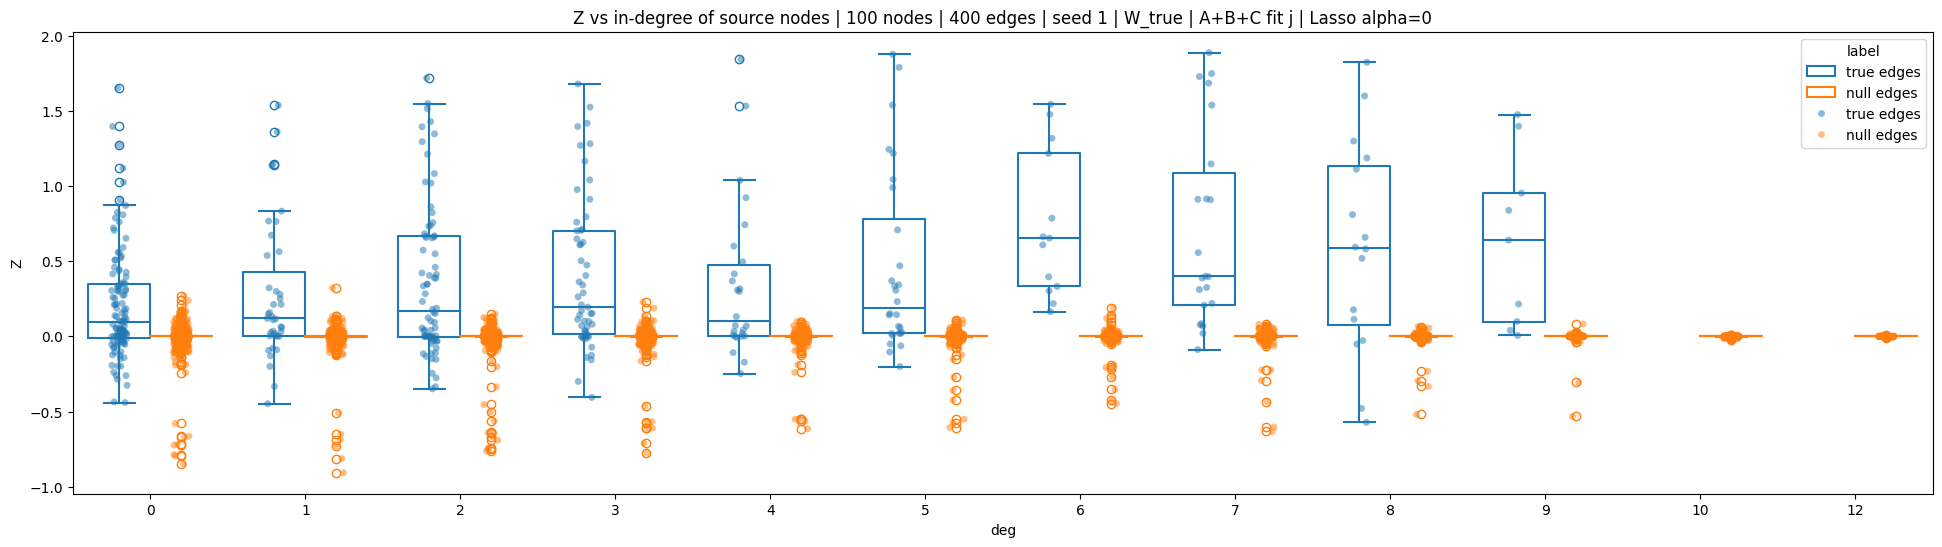

In [10]:
n_nodes = 100
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_1_lasso_OLS', notes='W_true | A+B+C fit j | Lasso alpha=0')

# B-weight_{C->B}*C to fit j, Lasso alpha=1, original knockoffDiagn
* doesn't work: all out edges of starting nodes are 0.

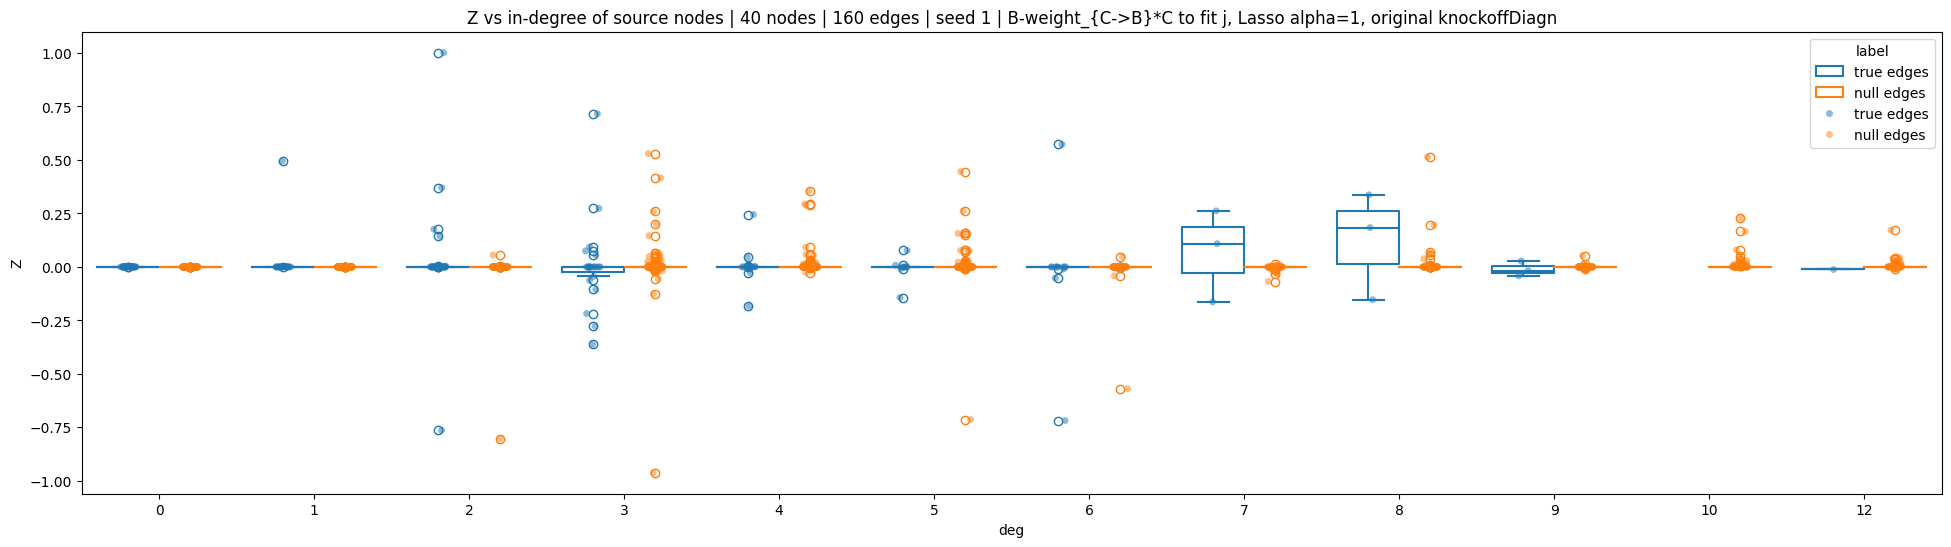

In [27]:
n_nodes = 40
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_4_lasso_sklearn', notes='B-weight_{C->B}*C to fit j, Lasso alpha=1, original knockoffDiagn')

Text(0.5, 1.0, 'distribution of out-degree edges of starting nodes of the above experiment')

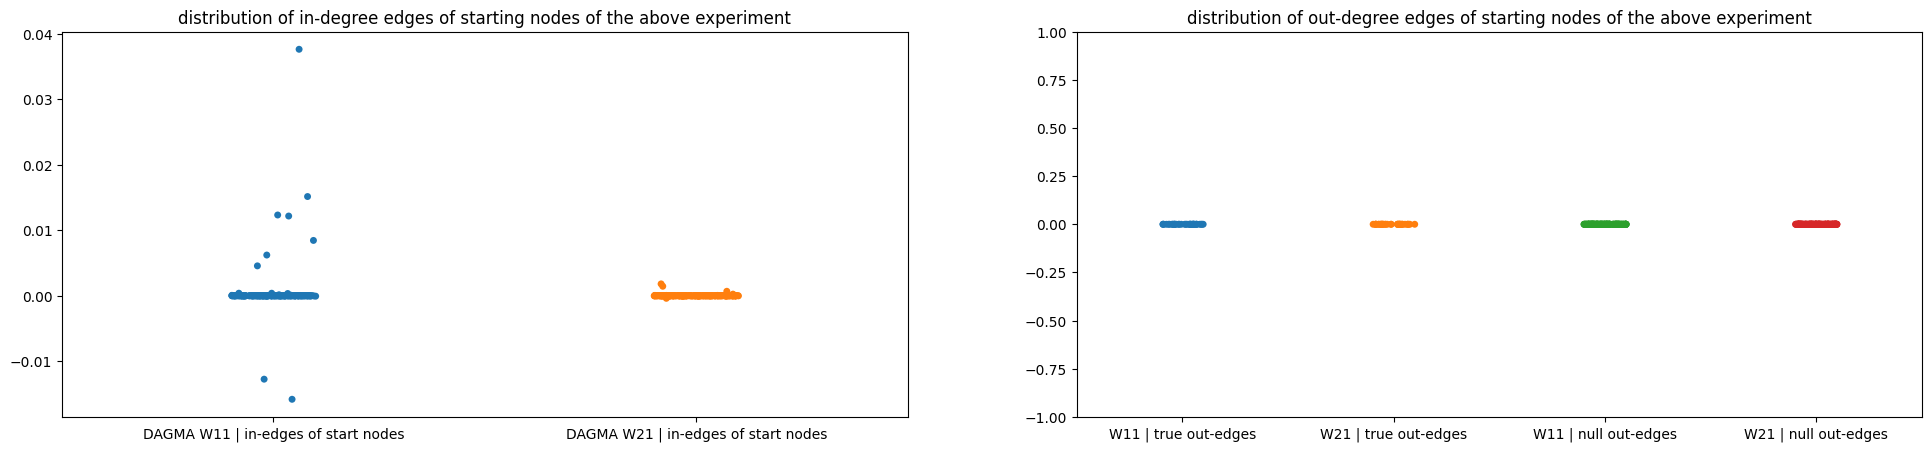

In [67]:
n_nodes = 40
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, seed=1, version_path = f'v44/v{n_nodes}_W_true_option_4_lasso_sklearn')
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
fig, ax = plt.subplots(1, 2, figsize=(24, 5))
_W11, _W21 = W11.copy(), W21.copy()
_W11[:, non_start_n] = -1000
_W21[:, non_start_n] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W21.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    # 'DAGMA W11 | true out-edges of start nodes': _W11_true[_W11_true != -1000],
    # 'DAGMA W21 | true out-edges of start nodes': _W21_true[_W21_true != -1000],
    'DAGMA W11 | in-edges of start nodes': _W11_null[_W11_null != -1000],
    'DAGMA W21 | in-edges of start nodes': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1, ax=ax[0])
plt.ylim([-1, 1])
ax[0].set_title(f"distribution of in-degree edges of starting nodes of the above experiment")

method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, seed=1, version_path = f'v44/v{n_nodes}_W_true_option_4_lasso_sklearn')
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
_W11, _W21 = W11.copy(), W21.copy()
_W11[non_start_n, :] = -1000
_W21[non_start_n, :] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W21.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    'W11 | true out-edges': _W11_true[_W11_true != -1000],
    'W21 | true out-edges': _W21_true[_W21_true != -1000],
    'W11 | null out-edges': _W11_null[_W11_null != -1000],
    'W21 | null out-edges': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1, ax=ax[1])
plt.ylim([-1, 1])
# plt.xticks(rotation=)
ax[1].set_title(f"distribution of out-degree edges of starting nodes of the above experiment")

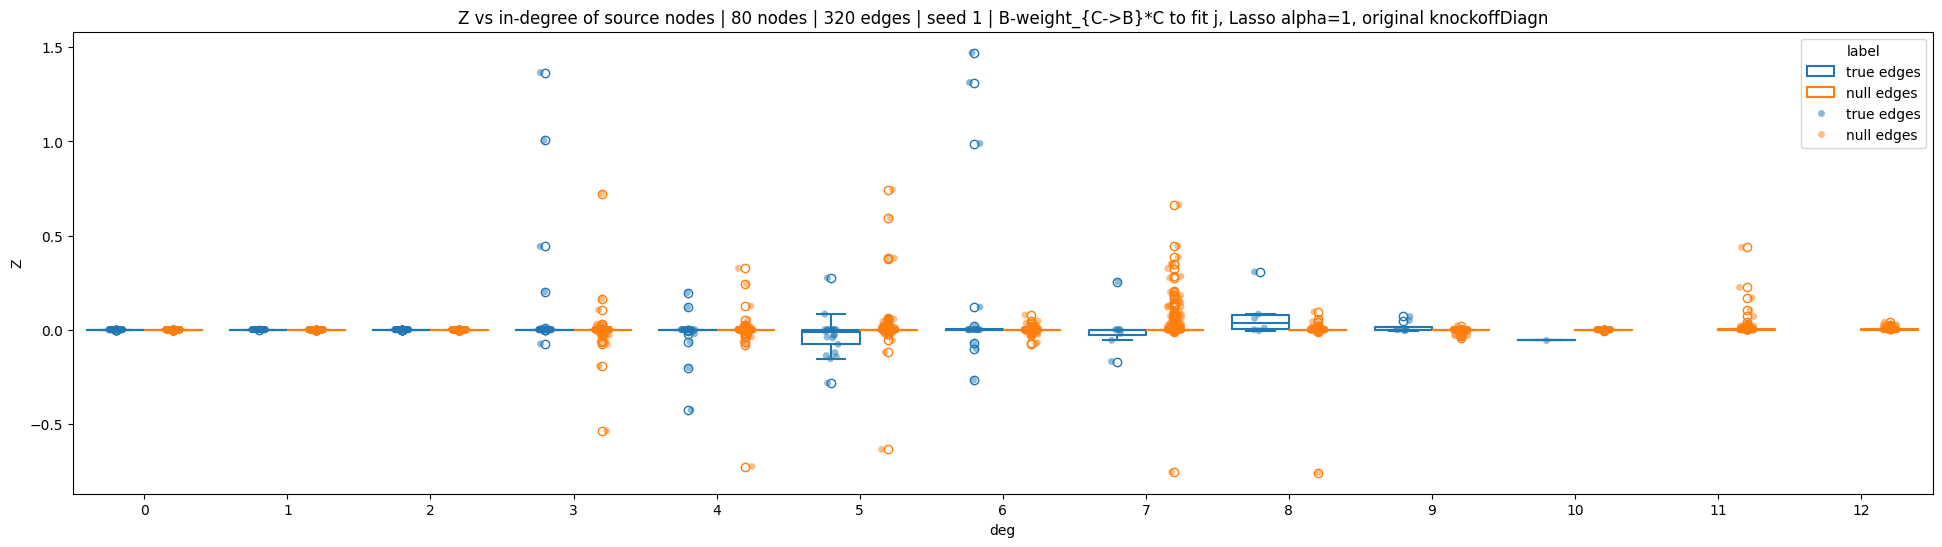

In [30]:
n_nodes = 80
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_4_lasso_sklearn', notes='B-weight_{C->B}*C to fit j, Lasso alpha=1, original knockoffDiagn')

Text(0.5, 1.0, 'distribution of out-degree edges of starting nodes of the above experiment')

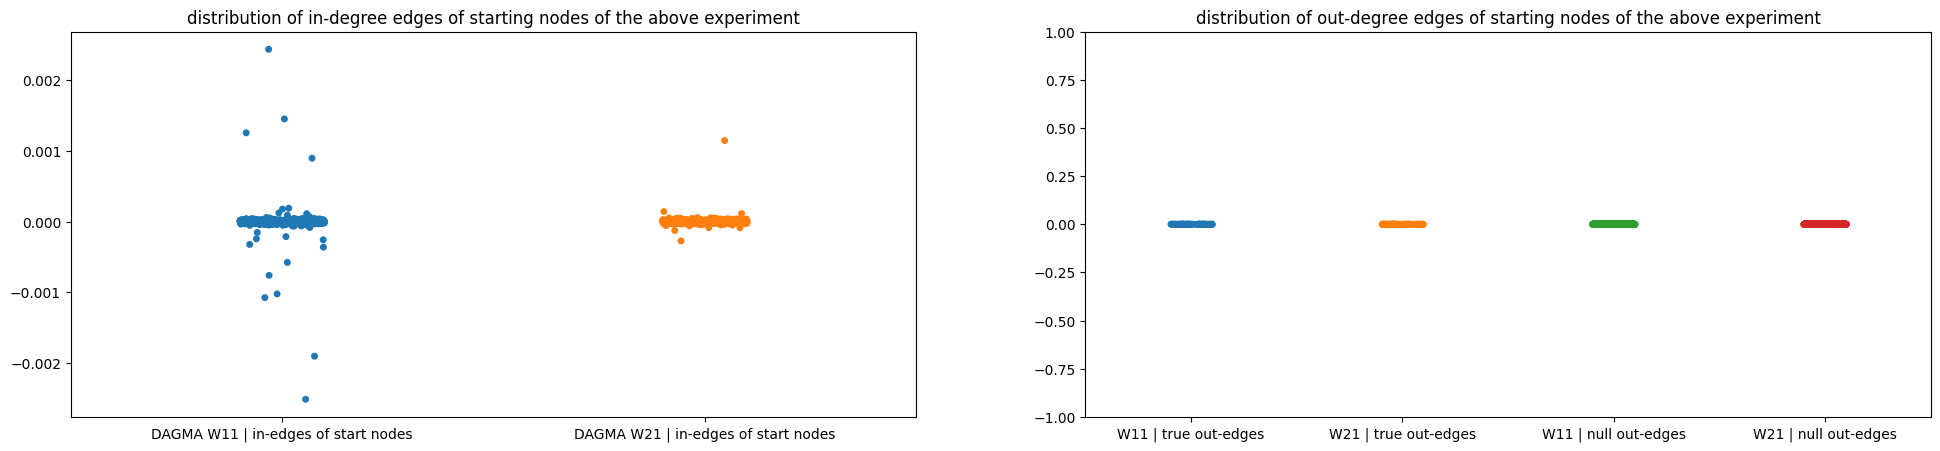

In [68]:
n_nodes = 80
method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, seed=1, version_path = f'v44/v{n_nodes}_W_true_option_4_lasso_sklearn')
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
fig, ax = plt.subplots(1, 2, figsize=(24, 5))
_W11, _W21 = W11.copy(), W21.copy()
_W11[:, non_start_n] = -1000
_W21[:, non_start_n] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W21.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    # 'DAGMA W11 | true out-edges of start nodes': _W11_true[_W11_true != -1000],
    # 'DAGMA W21 | true out-edges of start nodes': _W21_true[_W21_true != -1000],
    'DAGMA W11 | in-edges of start nodes': _W11_null[_W11_null != -1000],
    'DAGMA W21 | in-edges of start nodes': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1, ax=ax[0])
plt.ylim([-1, 1])
ax[0].set_title(f"distribution of in-degree edges of starting nodes of the above experiment")

method = 'elastic'
X, B_true, W_est, W_true = load_data(n_nodes, seed=1, version_path = f'v44/v{n_nodes}_W_true_option_4_lasso_sklearn')
W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
Z11_21 = get_Z(W_est, n_nodes=n_nodes)

out_deg = B_true.sum(axis=1)
in_deg = B_true.sum(axis=0)

start_n = np.where(in_deg == 0)[0]
all_n = list(range(X.shape[1]))
non_start_n = list(
    set(all_n).difference(set(start_n))
)
_W11, _W21 = W11.copy(), W21.copy()
_W11[non_start_n, :] = -1000
_W21[non_start_n, :] = -1000
_W11_true, _W11_null = _W11.copy(), _W11.copy()
_W21_true, _W21_null = _W21.copy(), _W21.copy()
_W11_true[~B_true] = -1000
_W21_true[~B_true] = -1000
_W11_null[B_true] = -1000
_W21_null[B_true] = -1000
data_dict = {
    'W11 | true out-edges': _W11_true[_W11_true != -1000],
    'W21 | true out-edges': _W21_true[_W21_true != -1000],
    'W11 | null out-edges': _W11_null[_W11_null != -1000],
    'W21 | null out-edges': _W21_null[_W21_null != -1000],
}
sns.stripplot(data_dict, alpha=1, ax=ax[1])
plt.ylim([-1, 1])
# plt.xticks(rotation=)
ax[1].set_title(f"distribution of out-degree edges of starting nodes of the above experiment")

# B-weight_{C->B}*C to fit j, Lasso alpha=0, original knockoffDiagn
* doesn't work: I suspect this case is similar to the one above - all out edges of starting nodes are 0.

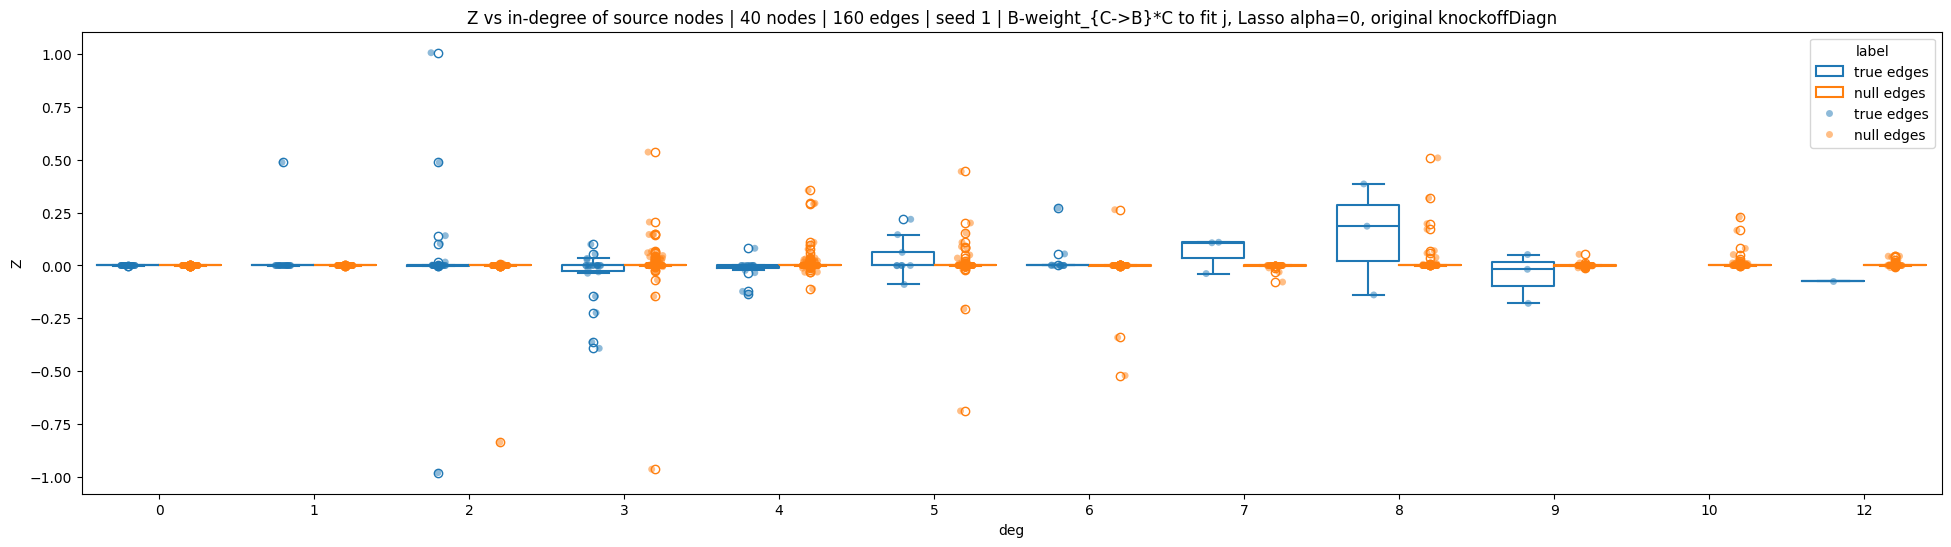

In [36]:
n_nodes = 40
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_4_lasso_OLS', notes='B-weight_{C->B}*C to fit j, Lasso alpha=0, original knockoffDiagn')

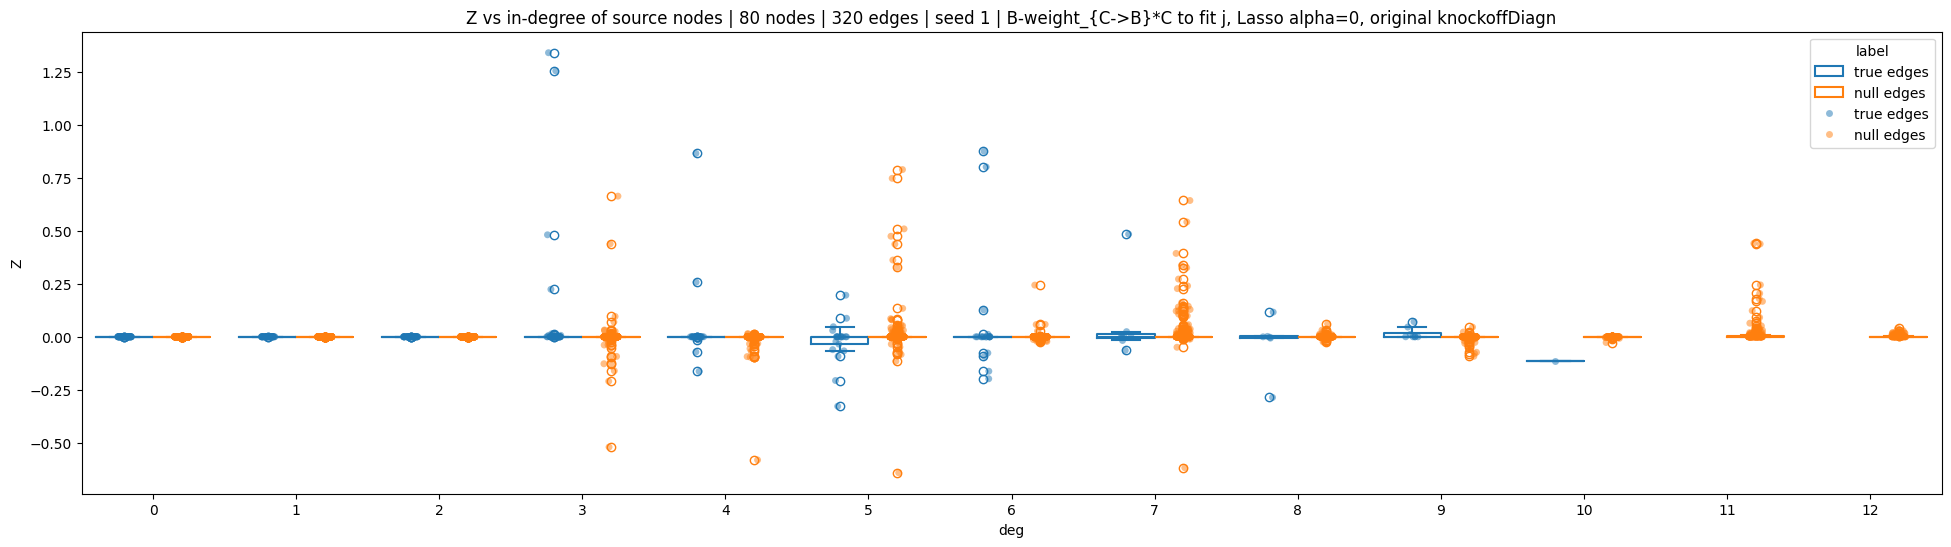

In [33]:
n_nodes = 80
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_4_lasso_OLS', notes='B-weight_{C->B}*C to fit j, Lasso alpha=0, original knockoffDiagn')

# A+B-weight_{C->B}*C to fit j, Lasso alpha=1, original knockoffDiagn
* doesn't work, the Z distribution shift still exists.

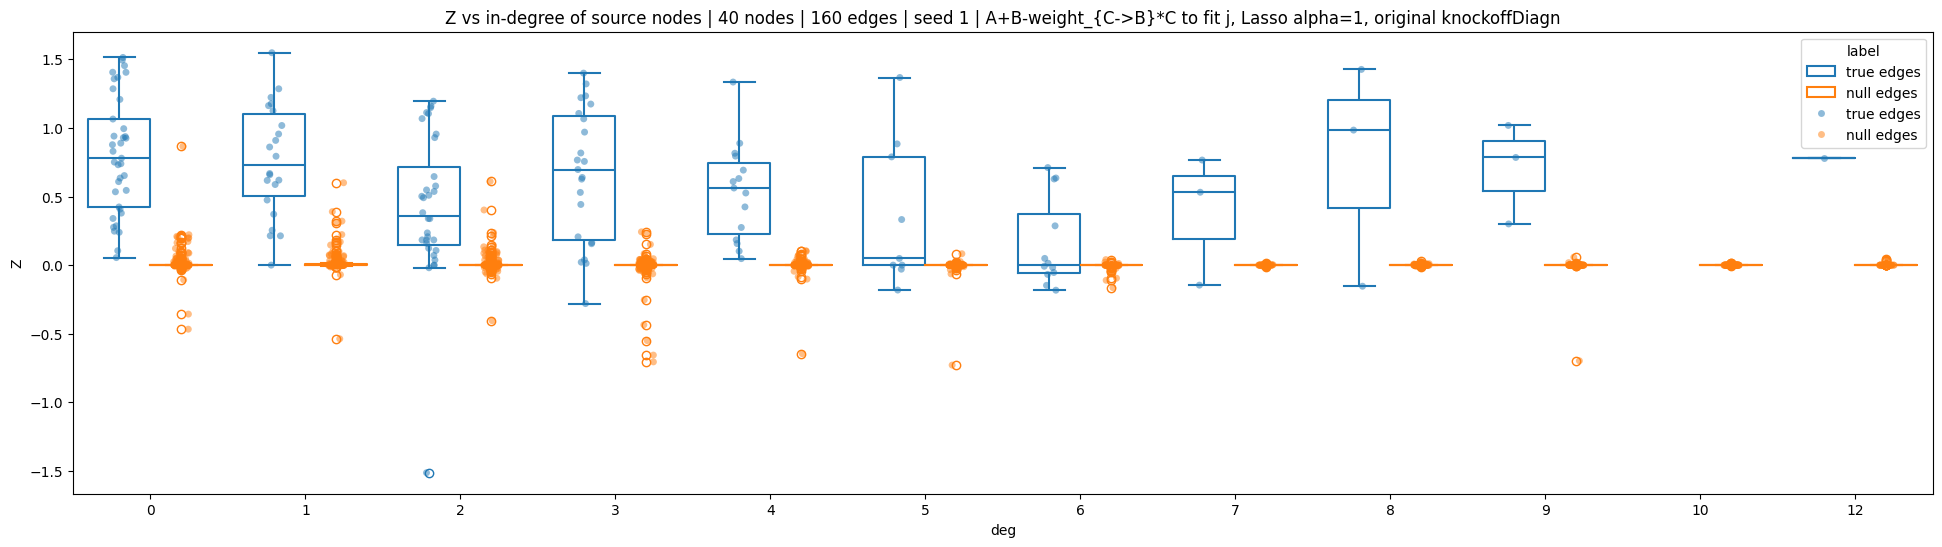

In [38]:
n_nodes = 40
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_5_lasso_sklearn', notes='A+B-weight_{C->B}*C to fit j, Lasso alpha=1, original knockoffDiagn')

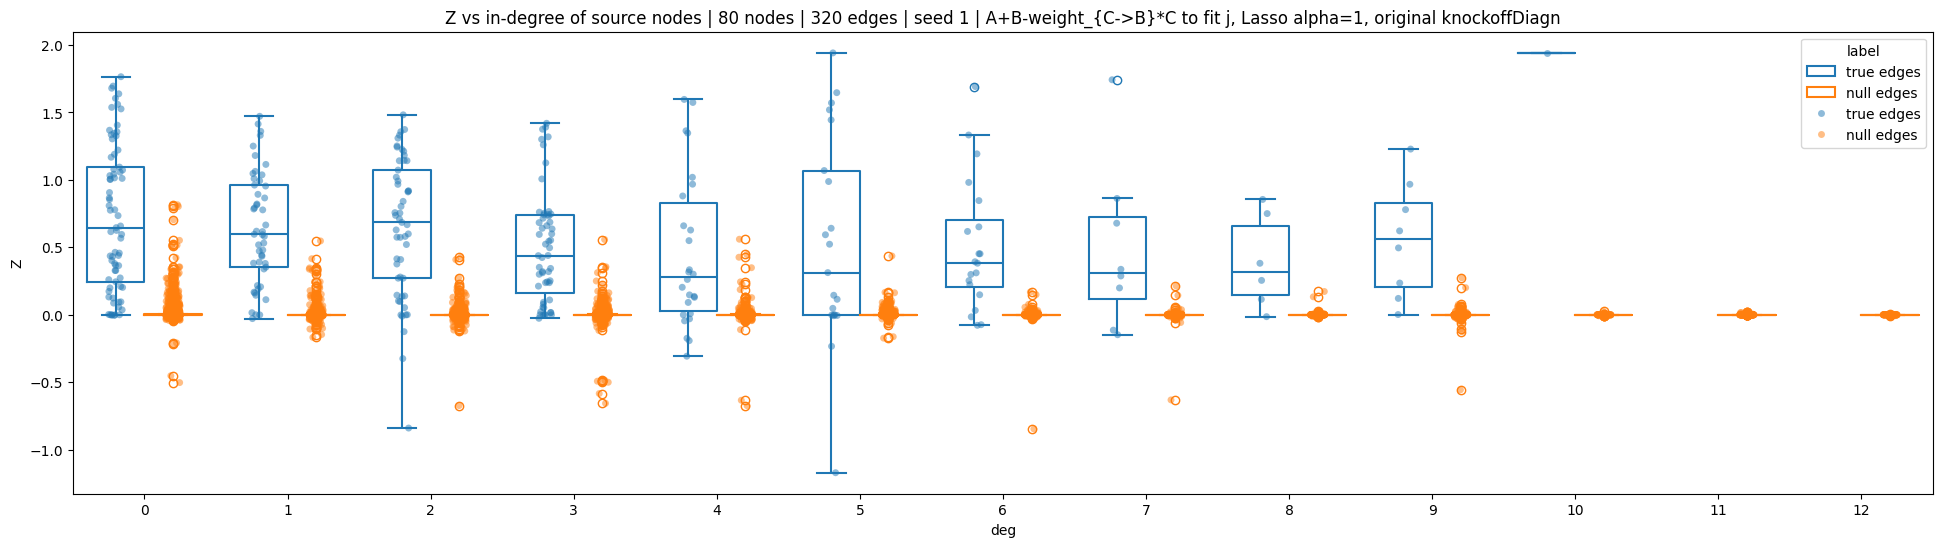

In [39]:
n_nodes = 80
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_5_lasso_sklearn', notes='A+B-weight_{C->B}*C to fit j, Lasso alpha=1, original knockoffDiagn')

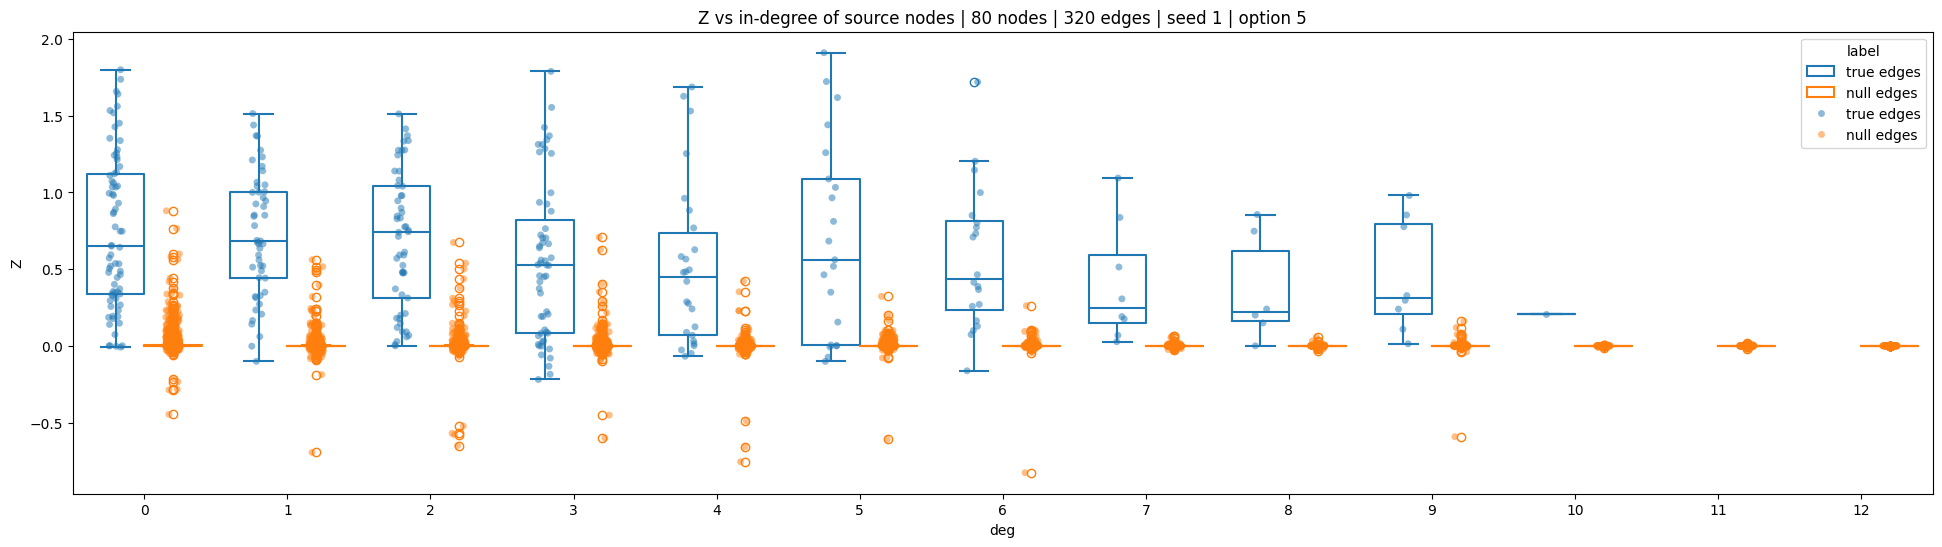

In [13]:
n_nodes = 80
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_est_option_5_lasso_sklearn', notes='option 5')

# A+B-weight_{C->B}*C to fit j, Lasso alpha=0, original knockoffDiagn
* the only case which works well

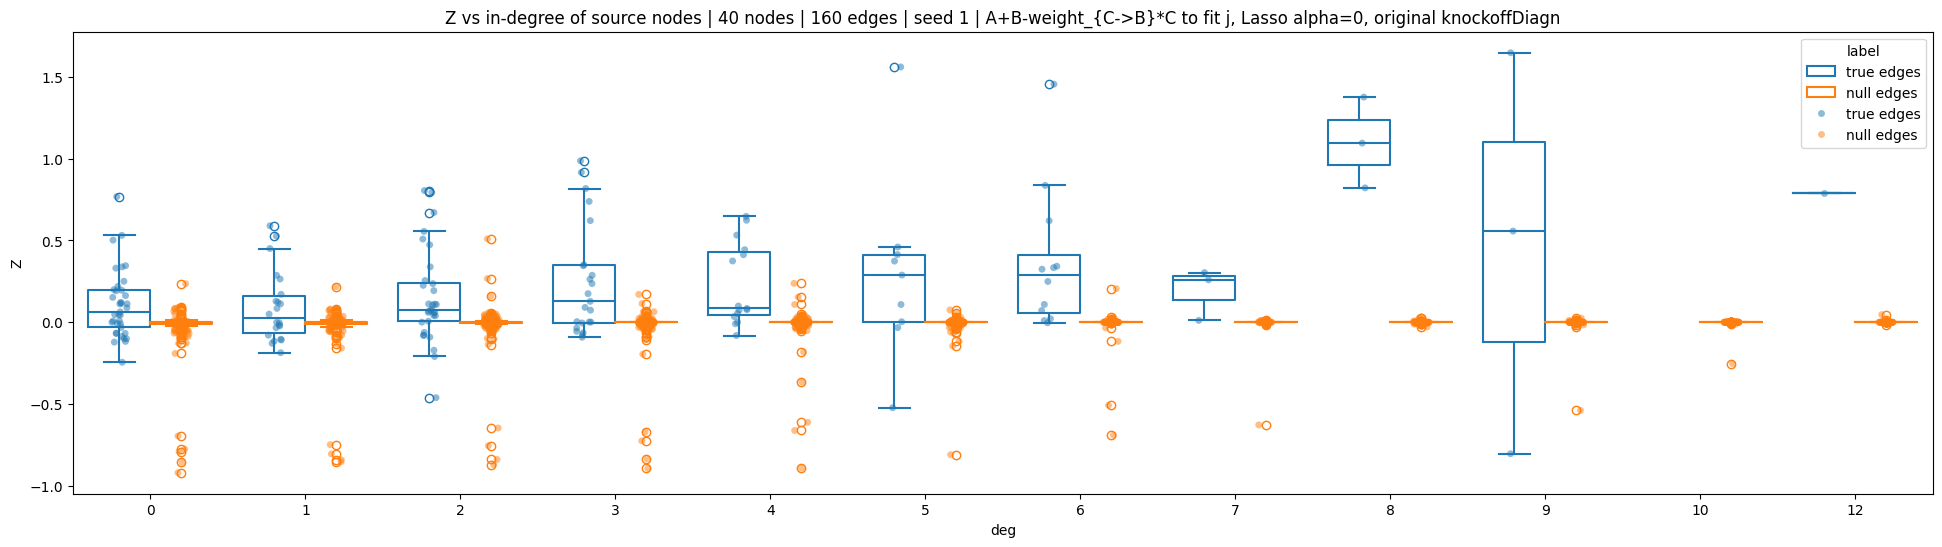

In [40]:
n_nodes = 40
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_5_lasso_OLS', notes='A+B-weight_{C->B}*C to fit j, Lasso alpha=0, original knockoffDiagn')

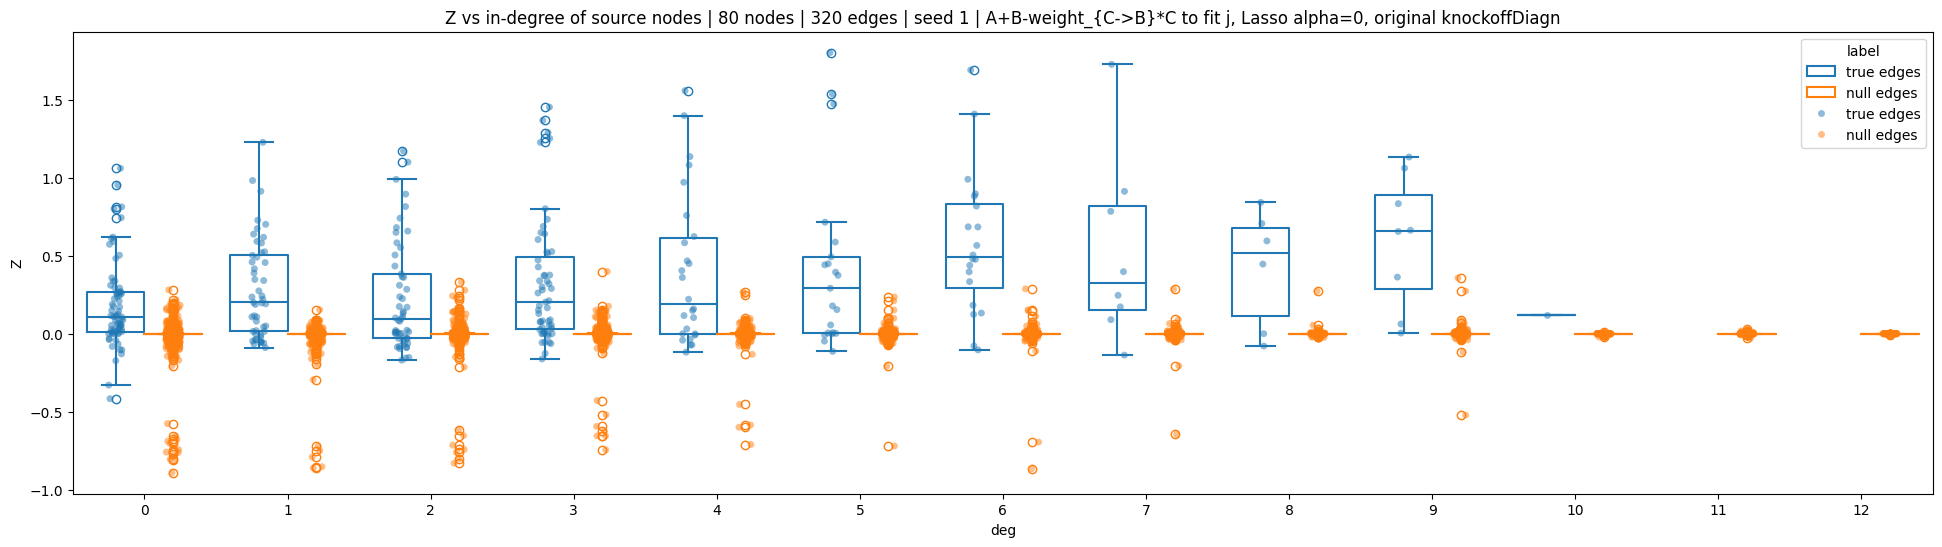

In [41]:
n_nodes = 80
df = sys_z0_vs_deg_box(n_nodes, f'v44/v{n_nodes}_W_true_option_5_lasso_OLS', notes='A+B-weight_{C->B}*C to fit j, Lasso alpha=0, original knockoffDiagn')